In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import numpy as np
import shapely.geometry as shpg
import os
import sys
import json
import logging

In [2]:
sys.path.append(os.getcwd() + '/../..')
from utils import mkdir, open_zip_shapefile, open_tar_shapefile, haversine

In [3]:
log = logging.getLogger('papermill')
logging.basicConfig(level='INFO', format="%(message)s")

## Files and storage paths

In [4]:
# Region of interest
reg = 6

# go down from rgi7_scripts/workflow
data_dir = '../../../../rgi7_data/'

# Input dirctory
input_dir_tar = os.path.join(data_dir, 'l4_rgi7b0_tar')
input_dir = os.path.join(data_dir, 'l4_rgi7b0')

### Load the input data

In [5]:
reg_file = os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O1Regions')
reg_file = gpd.read_file(reg_file)
fname = reg_file.loc[reg_file['o1region'] == f'{reg:02d}'].iloc[0]['long_code']

In [6]:
# Read beta files
shp = open_tar_shapefile(input_dir_tar + f'/RGI2000-v7.0-G-{fname}.tar.gz')
odf_subm = pd.read_csv(input_dir + f'/RGI2000-v7.0-G-{fname}/RGI2000-v7.0-G-{fname}_subm_info.csv', index_col=0)

## Printouts for docs 

In [7]:
for i, line in odf_subm.iterrows():
    print(f"Submission {i}")
    print(f": **Submitter**: {line['submitters']} ({line['chief_affl']})."
          f"<br/>**Number of outlines**: {line['n_outlines']}. **Area**: {line['area_km2']:.1f}km². **Release date**: {line['release_dt'][:10]}."
          f"<br/>**Analysts**: {line['analysts']}.")
    print(f"")

Submission 437
: **Submitter**: Sigurdsson, Oddur (National Energy Authority).<br/>**Number of outlines**: 26. **Area**: 7.1km². **Release date**: 2007-03-21.<br/>**Analysts**: Sigurdsson, Oddur.

Submission 438
: **Submitter**: Sigurdsson, Oddur (National Energy Authority).<br/>**Number of outlines**: 5. **Area**: 0.8km². **Release date**: 2007-03-21.<br/>**Analysts**: Sigurdsson, Oddur.

Submission 439
: **Submitter**: Sigurdsson, Oddur (National Energy Authority).<br/>**Number of outlines**: 154. **Area**: 95.2km². **Release date**: 2007-03-21.<br/>**Analysts**: Sigurdsson, Oddur.

Submission 452
: **Submitter**: Sigurdsson, Oddur (National Energy Authority).<br/>**Number of outlines**: 16. **Area**: 7.0km². **Release date**: 2007-03-21.<br/>**Analysts**: Sigurdsson, Oddur.

Submission 719
: **Submitter**: Sigurdsson, Oddur (University of Colorado).<br/>**Number of outlines**: 365. **Area**: 10947.5km². **Release date**: 2014-12-01.<br/>**Analysts**: Sigurdsson, Oddur.

Submission 7

In [8]:
odf_subm

,n_outlines,area_km2,anlys_time,release_dt,proc_desc,chief_affl,submitters,analysts,rc_id
subm_id,,,,,,,,,
437,26,7.126925,2005-01-01T00:00:00,2007-03-21T01:00:00,D; Glaciers were digitized directly from the s...,National Energy Authority,"Sigurdsson, Oddur","Sigurdsson, Oddur",22
438,5,0.782321,2005-01-01T00:00:00,2007-03-21T01:00:00,Drawn on screen from images; Glaciers were dig...,National Energy Authority,"Sigurdsson, Oddur","Sigurdsson, Oddur",22
439,154,95.163707,2005-01-01T00:00:00,2007-03-21T01:00:00,Drawn on DMA map according to photos; Glaciers...,National Energy Authority,"Sigurdsson, Oddur","Sigurdsson, Oddur",22
452,16,7.027451,2005-01-01T00:00:00,2007-03-21T01:00:00,Drawn on screen from images; Glaciers were dig...,National Energy Authority,"Sigurdsson, Oddur","Sigurdsson, Oddur",22
719,365,10947.544793,1993-09-01T00:00:00,2014-12-01T11:00:00,Manual glacier digitization from ASTER imagery...,University of Colorado,"Sigurdsson, Oddur","Sigurdsson, Oddur",761
757,2,2.057230,2021-10-01T00:00:00,2021-10-10T09:00:00,Re-ingest of outline based on ice-divide split...,National Energy Authority,"Sigurdsson, Oddur","Sigurdsson, Oddur",22


## Maps 

In [9]:
import salem
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from matplotlib.image import imread
import seaborn as sns

In [10]:
rdf = salem.read_shapefile(os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O1Regions', '00_rgi70_O1Regions.shp'))
srdf = salem.read_shapefile(os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O2Regions', '00_rgi70_O2Regions.shp'))

rdf = rdf.loc[rdf['o1region'] == f'{reg:02d}']
srdf = srdf.loc[srdf['o1region'] == f'{reg:02d}']

In [16]:
extent = [rdf.min_x.iloc[0], rdf.max_x.iloc[0], rdf.min_y.iloc[0], rdf.max_y.iloc[0]]
extent

[-26.0, -10.0, 59.0, 67.0]

In [45]:
extent = [-26.5, -9.5, 62, 67.5]

In [46]:
map_crs = ccrs.LambertConformal(
    central_longitude=(extent[0] + extent[1]) / 2,
    central_latitude=(extent[2] + extent[3]) / 2,
    standard_parallels=(64, 66),
)

In [47]:
shp_repr = shp.to_crs(map_crs)

N=26, A=7.1 km²
N=5, A=0.8 km²
N=154, A=95.2 km²
N=16, A=7.0 km²
N=365, A=10947.5 km²
N=2, A=2.1 km²


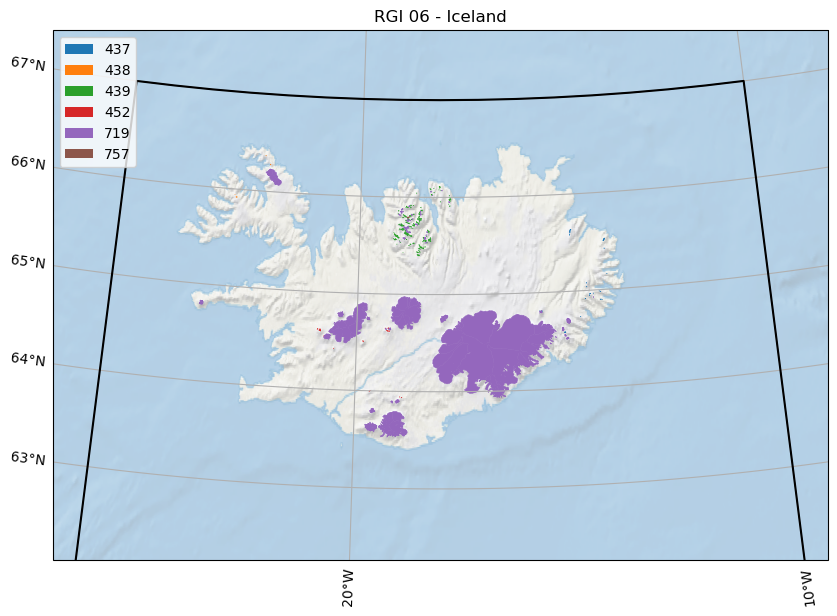

In [54]:
linewidth = 0.4
title = 'RGI 06 - Iceland' 
is_rgi6 = False

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=map_crs)
ax.set_extent(extent, crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, dms=True, 
                  xlocs=np.arange(37) * 10 - 180);
gl.top_labels = False
gl.right_labels = False

# fname = '/home/users/fmaussion/www_fmaussion/misc/rgi7_data/l0_support_data/images/natural-earth-1_large4096px.png'
fname = '/home/users/fmaussion/www_fmaussion/misc/rgi7_data/l0_support_data/images/natural-earth-1_large8192px_white.png'
fname = '/home/users/fmaussion/www_fmaussion/misc/rgi7_data/l0_support_data/images/natural-earth-1_large_white.png'
ax.imshow(imread(fname), origin='upper', transform=ccrs.PlateCarree(), 
          extent=[-180, 180, -90, 90])

rdf.to_crs(map_crs).plot(ax=ax, edgecolor='k', facecolor='none', zorder=3, linewidth=1.5)
srdf.to_crs(map_crs).plot(ax=ax, edgecolor='k', facecolor='none', zorder=2, linewidth=0.5)

handles = []
if is_rgi6:
    for itis in [True, False]:
        ec = '#001fff' if itis else '#ff0000'
        fc = '#465dff' if itis else '#ff4646'
        label = 'Same as RGI6' if itis else 'New in RGI7'
        s_loc = shp_repr.loc[shp_repr['is_rgi6'] == itis]
        if len(s_loc) > 0:
            s_loc.plot(ax=ax, facecolor=fc, edgecolor=ec, linewidth=linewidth, zorder=97)
            area = s_loc['area_km2'].sum()
        else:
            area = 0
        print(f'N={len(s_loc)}, A={area:.1f} km²')
        handles.append(mpatches.Patch(facecolor=ec, label=f'{label}'))
else:
    for i, subid in enumerate(sorted(shp.subm_id.unique().astype(int))):
        fc = f'C{i}'
        ec = fc
        s_loc = shp_repr.loc[shp.subm_id == subid]
        s_loc.plot(ax=ax, facecolor=fc, edgecolor=ec, linewidth=linewidth, zorder=1)
        area = s_loc['area_km2'].sum()
        handles.append(mpatches.Patch(facecolor=fc, label=f'{subid}'))
        print(f'N={len(s_loc)}, A={area:.1f} km²')

# Alternative solution for "Polygon handles not passing to legend"
ax.legend(handles=handles, loc='upper left');
ax.set_title(title);

plot_dir = data_dir + f'/l4_rgi7b0_plots/RGI{reg:02d}'
mkdir(plot_dir)
plotname = 'isrgi6_map' if is_rgi6 else 'inventory_map'
plt.savefig(plot_dir + f'/{plotname}.jpeg', bbox_inches='tight', dpi=300)

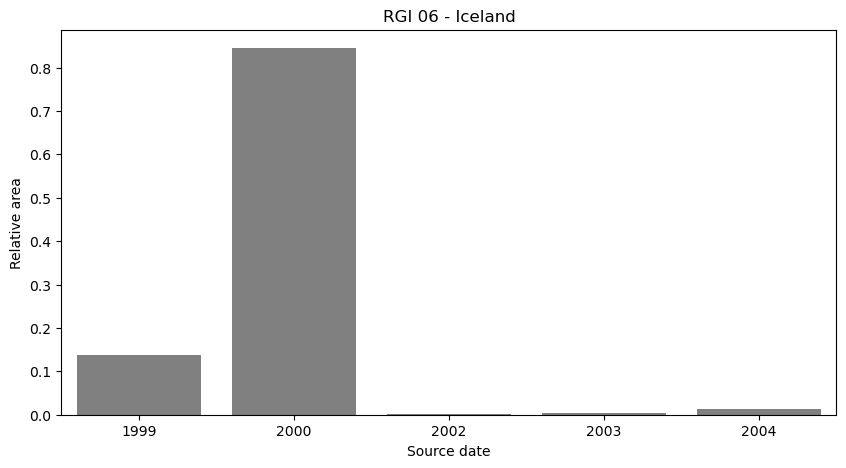

In [38]:
figsize=(10, 5)

f, ax = plt.subplots(figsize=figsize)

date = shp['src_date'].str[:4].astype(int).to_frame('src_date')
date['area'] = shp['area_km2']
date = date.groupby('src_date')['area'].sum().to_frame()
# if reset_index:
#     date = date.reindex(np.arange(date.index.min(), date.index.max()+1, dtype=int), fill_value=0)
date['area'] = date['area'] / date['area'].sum()
date = date.reset_index()

sns.barplot(ax=ax, x='src_date', y='area', data=date, color='grey');
ax.set_ylabel('Relative area'); ax.set_xlabel('Source date'); 
ax.set_title(title);
# plt.xticks(rotation=45, ha='center')

plot_dir = data_dir + f'/l4_rgi7b0_plots/RGI{reg:02d}'
mkdir(plot_dir)
plotname = 'date_hist'
plt.savefig(plot_dir + f'/{plotname}.png', bbox_inches='tight', dpi=300)